In [55]:
#import warnings
#warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
import scipy.stats as stats
import sklearn.impute as simpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler


import acquire
import prepare
import explore
import env

univariate
    continous
        - histogram
        - boxplot
        - displot
    discrete
        - countplot


bi-/mulit-variate
    continous with continous
        - scatter
        - line
        - pair
        - heat map
        - relplot
    discrete with continous
        - violin
        - catplot
        - sunburst?
        - boxplot
        - swarmplot
        - striplot
    discrete with discrete
        - heatmap
        -
        -


In [56]:
# get the data and review the data

#fips is a unique identifier published by the usda.gov
#06037	Los Angeles	CA
#06059	Orange	CA
#06111	Ventura	CA

df0 = acquire.get_zillow_single_fam()

## datatypes look good with 2,152,863 records
print(df0.info(null_counts=True)) 
print("----------------------------")

## start the clean up
## remove cells with whitespace and replace with NaN in a new working dataframe

df = df0.replace(r'^\s*$', np.nan, regex=True)
df = df.rename(columns = {"bedroomcnt":"bedrooms",
                            "bathroomcnt":"bathrooms",
                            "calculatedfinishedsquarefeet":"area",
                            "taxvaluedollarcnt":"tax value",
                            "taxamount":"taxes yearly",
                            "yearbuilt":"year built"
                            })


## drop n/a and review
print(df.isnull().sum(), "\n \t nulls prior to drop")
print("----------------------------")

df = df.dropna()

print(df.isnull().sum(), "\n \t nulls post drop")
print("----------------------------")


##ranges on these look very crazy, diving deeper
for col in df.columns:
    print("range of",col, ": {:,}".format((df[col].describe()["max"] - df[col].describe()["min"]).astype(int)), "({:,}".format(df[col].describe()["max"]), "max - min {:,})".format(df[col].describe()["min"]))

# 2,140,235 records
df.describe().T

/var/folders/c6/16b7dgw96t19zlzn79g4rd9r0000gn/T/ipykernel_55934/584791023.py:11: FutureWarning: null_counts is deprecated. Use show_counts instead
  print(df0.info(null_counts=True))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2152863 entries, 0 to 2152862
Data columns (total 7 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   bedroomcnt                    2152852 non-null  float64
 1   bathroomcnt                   2152852 non-null  float64
 2   calculatedfinishedsquarefeet  2144379 non-null  float64
 3   taxvaluedollarcnt             2152370 non-null  float64
 4   yearbuilt                     2143526 non-null  float64
 5   taxamount                     2148421 non-null  float64
 6   fips                          2152863 non-null  float64
dtypes: float64(7)
memory usage: 131.4 MB
None
----------------------------
bedrooms          11
bathrooms         11
area            8484
tax value        493
year built      9337
taxes yearly    4442
fips               0
dtype: int64 
 	 nulls prior to drop
----------------------------
bedrooms        0
bathrooms       0
area          

count           mean            std      min        25%  \
bedrooms      2140235.0       3.301419       0.932600     0.00       3.00   
bathrooms     2140235.0       2.240352       0.990549     0.00       2.00   
area          2140235.0    1863.193970    1221.754161     1.00    1258.00   
tax value     2140235.0  460641.625164  677157.635675    22.00  189166.00   
year built    2140235.0    1960.967545      22.150563  1801.00    1949.00   
taxes yearly  2140235.0    5616.711322    7814.562798     6.34    2540.85   
fips          2140235.0    6048.309556      20.344910  6037.00    6037.00   

                    50%        75%          max  
bedrooms           3.00       4.00        25.00  
bathrooms          2.00       3.00        32.00  
area            1623.00    2208.00    952576.00  
tax value     328296.00  534606.00  90188462.00  
year built      1958.00    1976.00      2016.00  
taxes yearly    4111.47    6411.93   1078101.87  
fips            6037.00    6059.00      6111.00

In [57]:
df.drop(columns=["fips"]).columns.tolist()

['bedrooms', 'bathrooms', 'area', 'tax value', 'year built', 'taxes yearly']

In [58]:
## def not looking correct. a single family house with 25 bedrooms? 32 bathrooms? almost a million sqft? 1mil in taxes a year?
## if looking for model to predict, i'm going to remove outliers that would skew data
## used tukey to remove outliers


## dropping <1 bathroom counts, since that's a code violation for a single family unit (requirement)
## also dropping <1 bedroom counts, since studios should not be considered a single family residence

## dropping any homes with less than 320sqft due to International Residential Code (IRC). 
## The IRC codes require that all homes must be built on a minimum of 320 square feet.

#tukey_k = 1.5
#
#for col in df.drop(columns=["fips"]).columns:
#       IQR = (df[col].describe()["75%"] - df[col].describe()["25%"])
#       df = df[(df[col] < (df[col].describe()["75%"] + (IQR * tukey_k))) & \
#            (df[col] > (df[col].describe()["25%"] - (IQR * tukey_k)))]
#

## using 3x STD from MEAN to determine retention
## using 3 sigma for deviation allowance to capture 99.7% (removing the extreme outliers)
#for col in temp_list:
#    df = df[(df[col] < (df[col].describe()["mean"] + df[col].describe()["std"]*3)) & \
#            (df[col] > (df[col].describe()["mean"] - df[col].describe()["std"]*3))]


#df = df[df.bathrooms>=1]
#df = df[df.bedrooms>=1]
#df = df[df.area>320]
#df = df[df.bathrooms != 1.75]

#df["decade built"] = (df["year built"]//10 *10).astype(int).astype(str) + "s"


df.describe().T

count           mean            std      min        25%  \
bedrooms      2140235.0       3.301419       0.932600     0.00       3.00   
bathrooms     2140235.0       2.240352       0.990549     0.00       2.00   
area          2140235.0    1863.193970    1221.754161     1.00    1258.00   
tax value     2140235.0  460641.625164  677157.635675    22.00  189166.00   
year built    2140235.0    1960.967545      22.150563  1801.00    1949.00   
taxes yearly  2140235.0    5616.711322    7814.562798     6.34    2540.85   
fips          2140235.0    6048.309556      20.344910  6037.00    6037.00   

                    50%        75%          max  
bedrooms           3.00       4.00        25.00  
bathrooms          2.00       3.00        32.00  
area            1623.00    2208.00    952576.00  
tax value     328296.00  534606.00  90188462.00  
year built      1958.00    1976.00      2016.00  
taxes yearly    4111.47    6411.93   1078101.87  
fips            6037.00    6059.00      6111.00

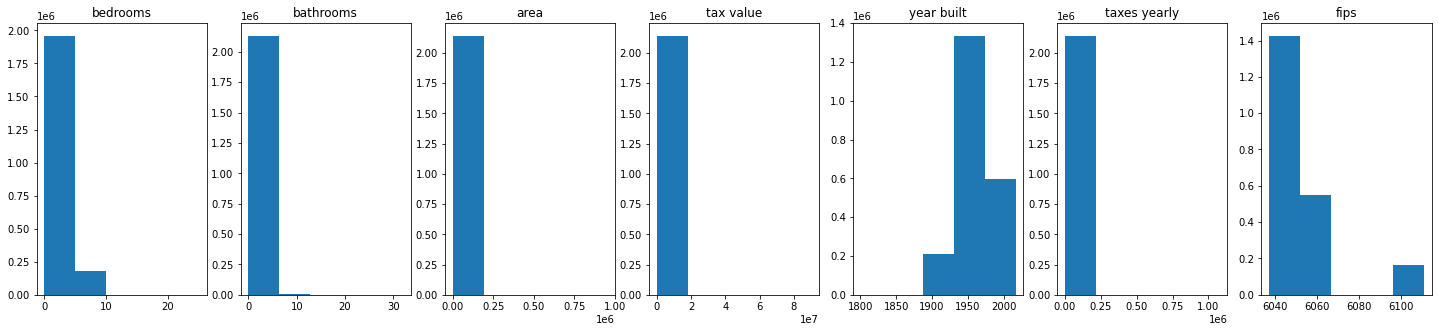

In [59]:
##checking the distribution now that the outliers are removed

plt.figure(figsize=(25, 5))

# List of columns
cols = df.columns.tolist()

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)

In [60]:
## prep is all the stuff above minus the graphs and print statements

df,train,validate,test = prepare.prep_zillow()

cat_vars = ["bedrooms","bathrooms","decade built","fips"]
num_vars = ["area","tax value", "taxes yearly"]

df

bedrooms  bathrooms    area  tax value  year built  taxes yearly  \
7             3.0        2.0  2077.0   646760.0      1926.0       7924.68   
18            3.0        1.0  1244.0   169471.0      1950.0       2532.88   
19            3.0        2.0  1300.0   233266.0      1950.0       3110.99   
20            3.0        2.0  1222.0   290492.0      1951.0       3870.25   
40            2.0        1.0   725.0    37548.0      1953.0        576.47   
...           ...        ...     ...        ...         ...           ...   
2152815       4.0        2.0  1484.0    71859.0      1955.0       1135.72   
2152824       2.0        1.0   710.0   175319.0      1940.0       2040.78   
2152831       3.0        2.0  1194.0   271536.0      1954.0       3555.73   
2152852       3.0        2.0  1917.0   408680.0      1946.0       4341.32   
2152853       4.0        2.0  1987.0   259913.0      1955.0       3175.66   

           fips decade built  
7        6037.0        1920s  
18       6037.0        1950s  
19       6037.0        1950s  
20       6037.0        1950s  
40       6037.0        1950s  
...         ...          ...  
2152815  6037.0        1950s  
2152824  6111.0        1940s  
2152831  6037.0        1950s  
2152852  6111.0        1940s  
2152853  6059.0        1950s  

[1799429 rows x 8 columns]

In [61]:
train

bedrooms  bathrooms    area  tax value  year built  taxes yearly  \
1222525       2.0        1.0  1012.0   294422.0      1949.0       4149.40   
1382660       3.0        2.0  1961.0   627384.0      1953.0       7124.10   
2094882       3.0        2.0  1271.0   328921.0      1956.0       4027.52   
1791732       3.0        2.0  1474.0   542190.0      1927.0       6437.48   
933597        4.0        3.0  2268.0   540066.0      1973.0       6823.28   
...           ...        ...     ...        ...         ...           ...   
1491561       3.0        2.0  1975.0   193653.0      1942.0       2509.65   
1068135       4.0        2.0  2019.0   227067.0      1976.0       3457.68   
1451731       3.0        2.0  1502.0   324583.0      1976.0       3786.58   
1684469       3.0        2.0  1231.0   208556.0      1950.0       2741.15   
1907432       3.0        2.0  2449.0   129932.0      1978.0       1788.21   

           fips decade built  
1222525  6037.0        1940s  
1382660  6037.0        1950s  
2094882  6037.0        1950s  
1791732  6037.0        1920s  
933597   6037.0        1970s  
...         ...          ...  
1491561  6037.0        1940s  
1068135  6037.0        1970s  
1451731  6059.0        1970s  
1684469  6037.0        1950s  
1907432  6037.0        1970s  

[1079657 rows x 8 columns]

-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-

exploration: initial steps

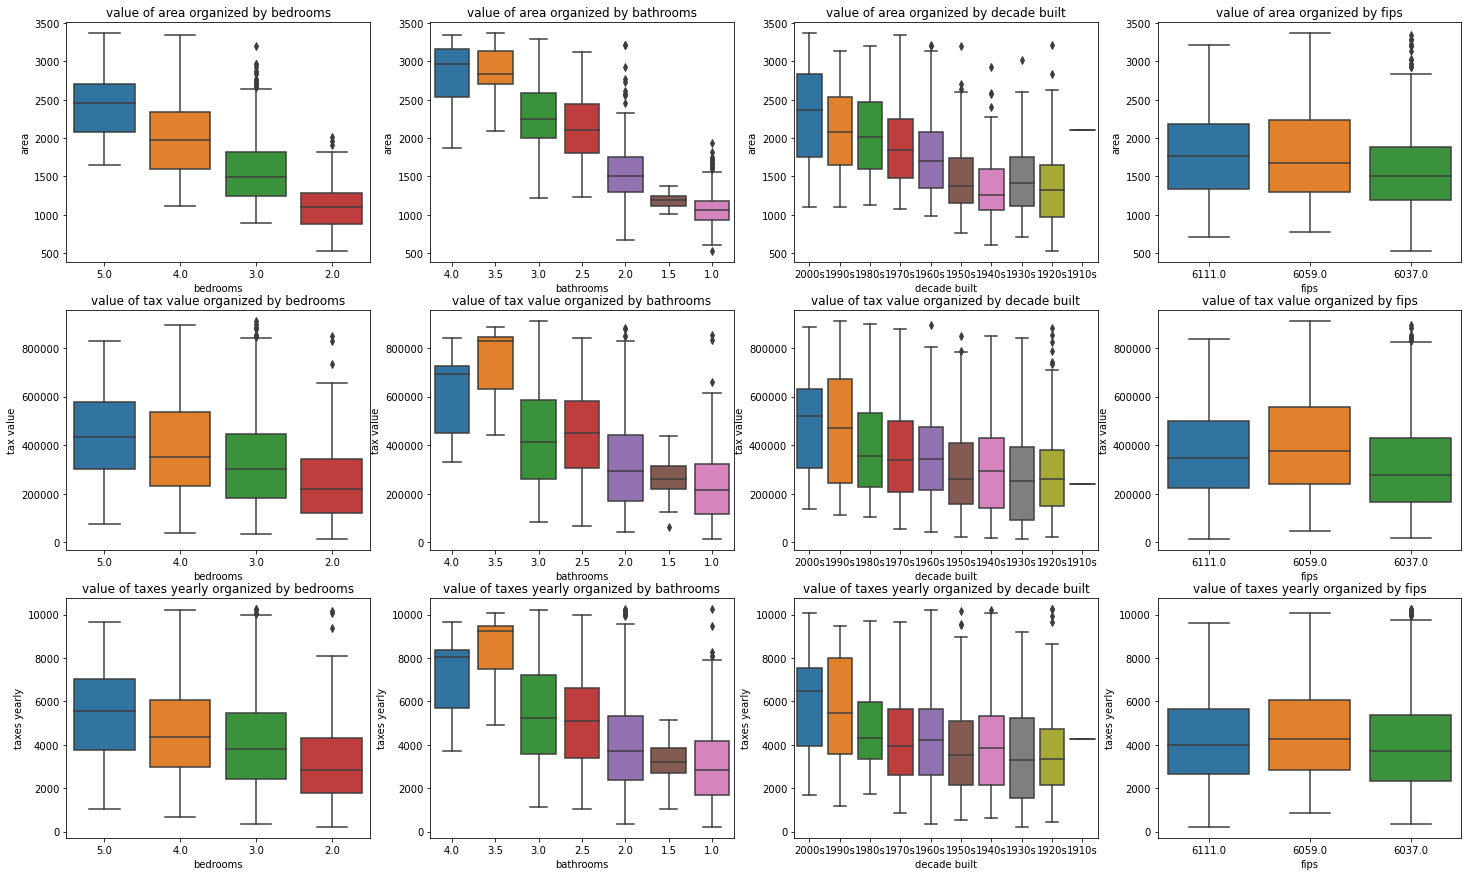

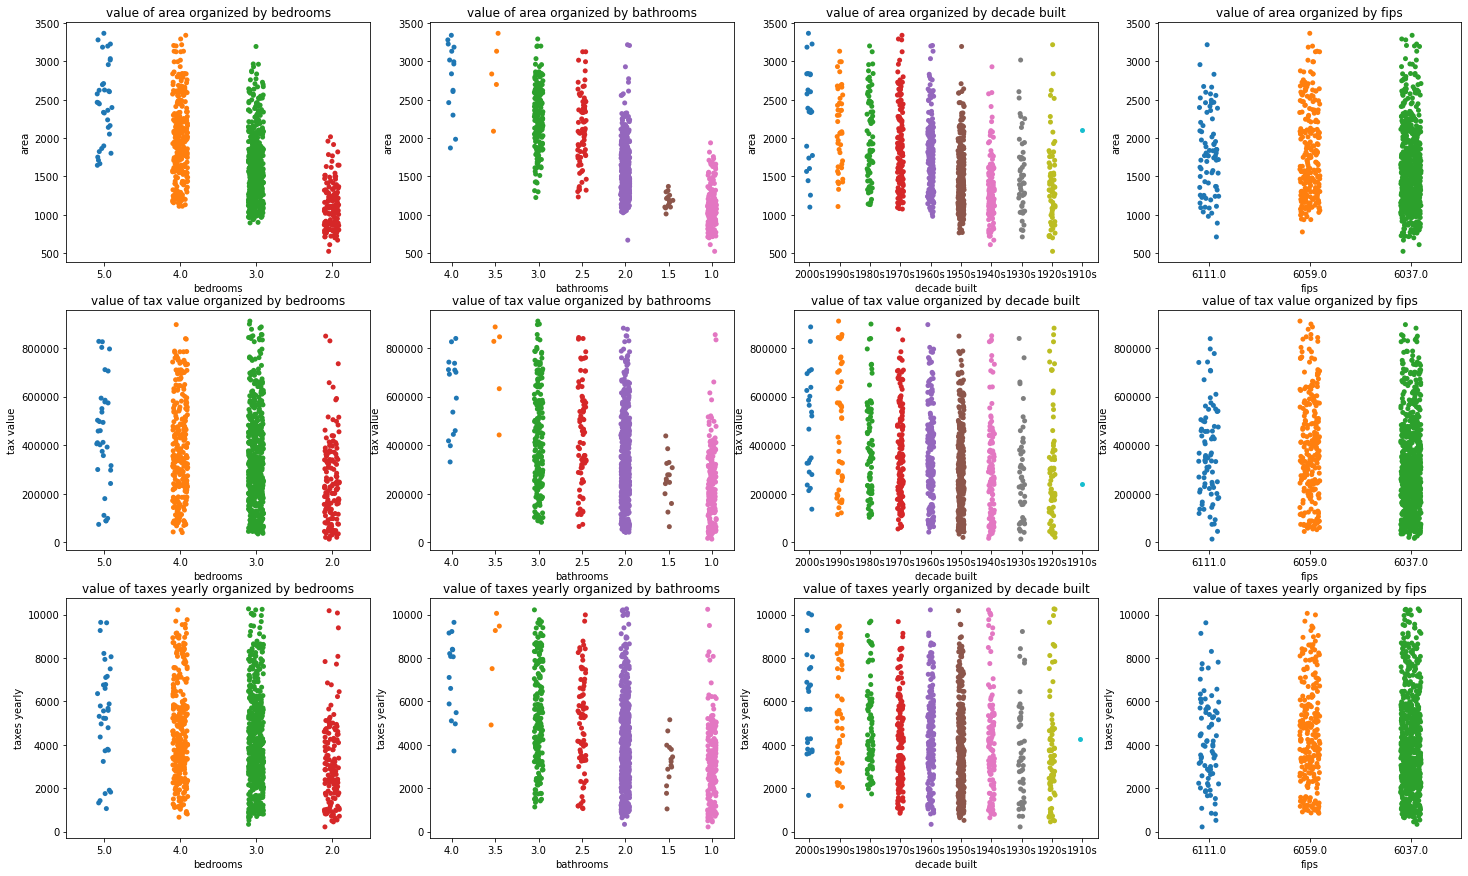

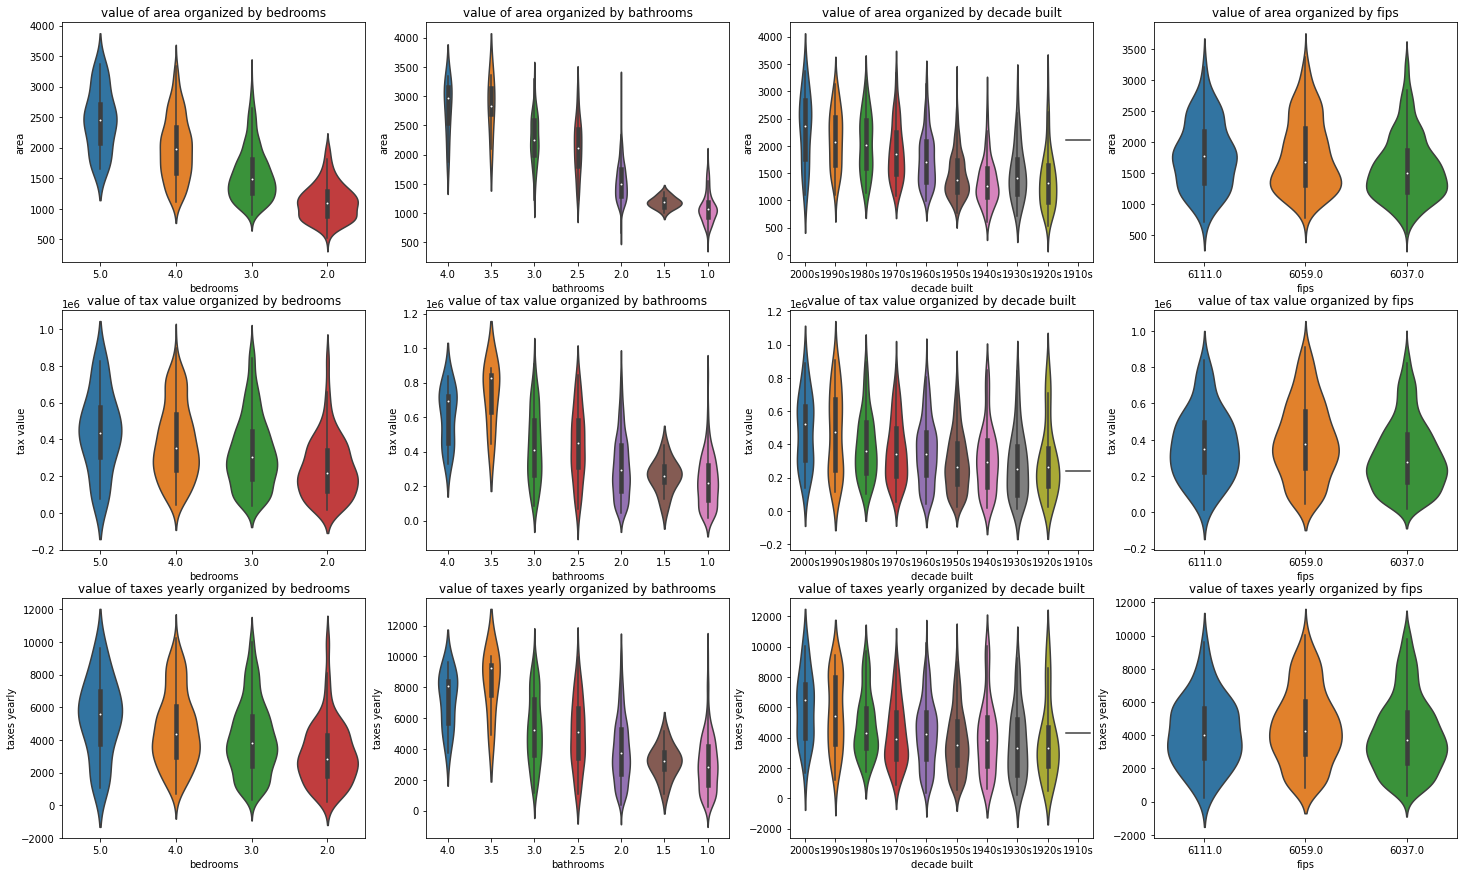

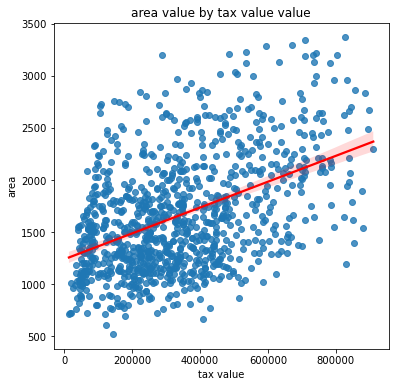

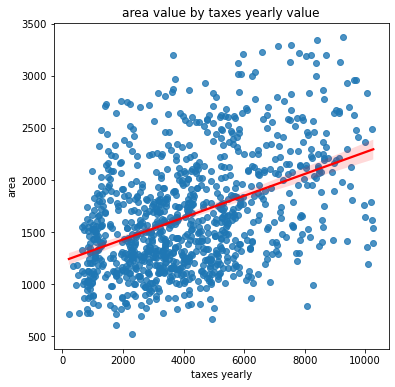

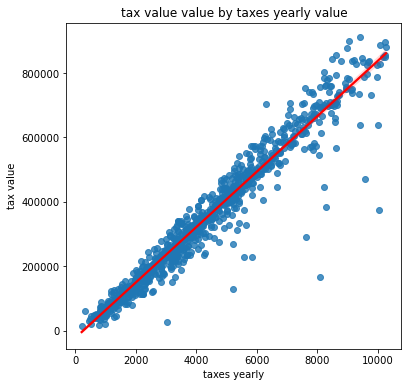

<Figure size 432x432 with 0 Axes>

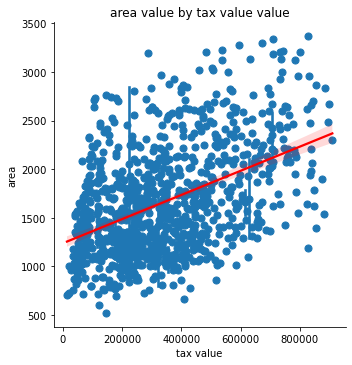

<Figure size 432x432 with 0 Axes>

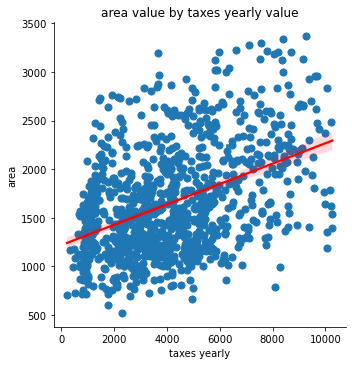

<Figure size 432x432 with 0 Axes>

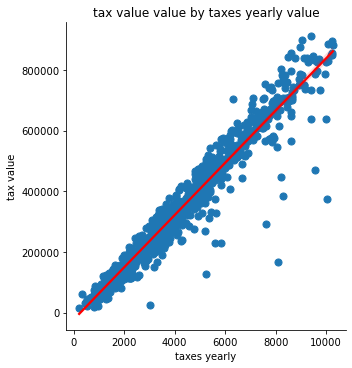

<Figure size 432x432 with 0 Axes>

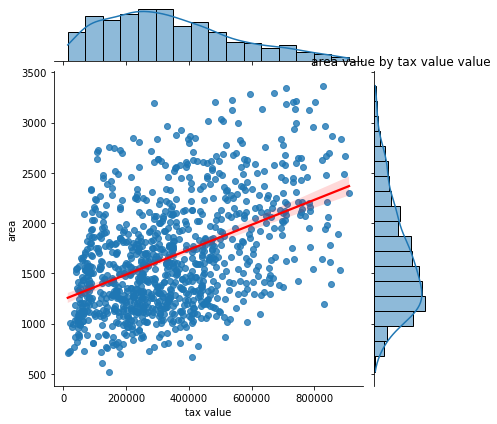

<Figure size 432x432 with 0 Axes>

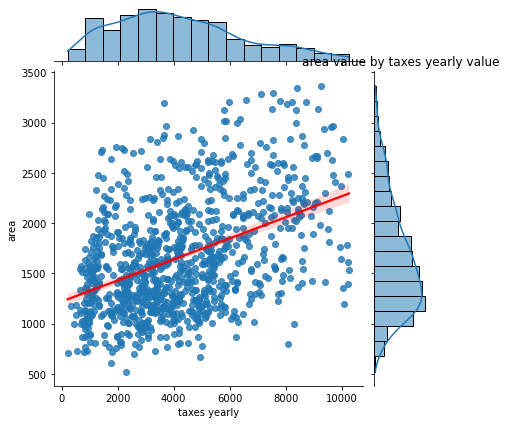

<Figure size 432x432 with 0 Axes>

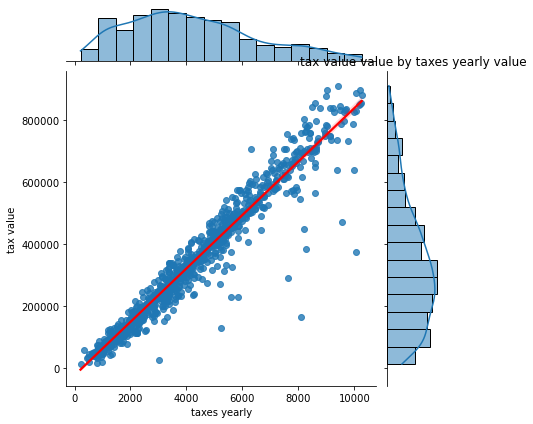

In [62]:
explore.plot_categorical_and_continuous_vars(train,num_vars,cat_vars)
explore.plot_variable_pairs(train,num_vars)

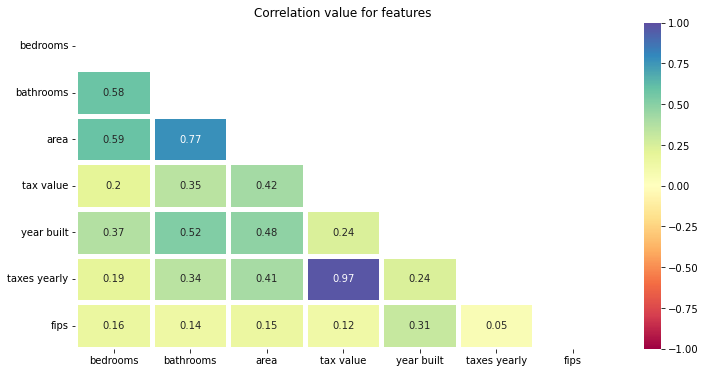

In [63]:
## create a heatmap of relationships between the variables

plt.figure(figsize=(12, 6))
kwargs = {'alpha':1,
        'linewidth':5, 
        'linestyle':'--',
        'linecolor':'white'}

sns.heatmap(    train.corr(),
                #map="YlGnBu", 
                cmap="Spectral",
                mask=(np.triu(np.ones_like(train.corr(),dtype=bool))),
                annot=True,
                vmin=-1, 
                vmax=1, 
                #annot=True,
                **kwargs
                )
plt.title("Correlation value for features")
plt.show()

# Heatmap takeaways:
strong relationship between tax value and  taxes yearly (makes sense since your taxes yearly is based off tax value)

as well as area and bathrooms (also makes sense, larger house has more room for bathroom)




> - **Hypothesis 1 -** 
> - alpha = .05
> - $H_0$ = "That the distributions underlying the samples of Tax Value and Taxes Yearly are unrelated"
> -
> - $H_a$: "That the distributions underlying the samples of Tax Value and Taxes Yearly are related"

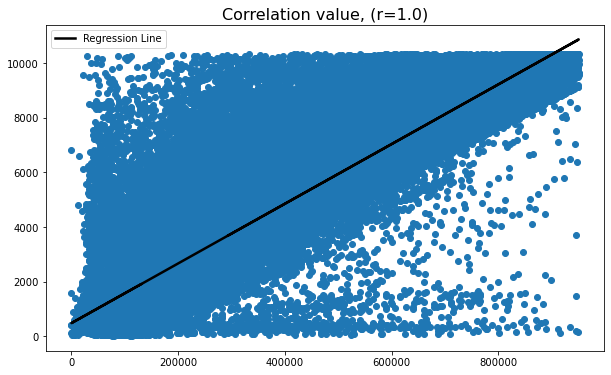

r = 0.970309851214055

 We reject the null Hypothesis ( T̶h̶a̶t̶ ̶t̶h̶e̶ ̶d̶i̶s̶t̶r̶i̶b̶u̶t̶i̶o̶n̶s̶ ̶u̶n̶d̶e̶r̶l̶y̶i̶n̶g̶ ̶t̶h̶e̶ ̶s̶a̶m̶p̶l̶e̶s̶ ̶o̶f̶ ̶T̶a̶x̶ ̶V̶a̶l̶u̶e̶ ̶a̶n̶d̶ ̶T̶a̶x̶e̶s̶ ̶Y̶e̶a̶r̶l̶y̶ ̶a̶r̶e̶ ̶u̶n̶r̶e̶l̶a̶t̶e̶d̶ ) p=0.00000


In [64]:
## putting tax value and taxes yearly into a pearsonr and then graphing it for a visual result as a result
## of the heat map above highlighting a good possibility of a relation


H0 = "That the distributions underlying the samples of Tax Value and Taxes Yearly are unrelated"
Ha = "That the distributions underlying the samples of Tax Value and Taxes Yearly are related"
alpha = .05


r, p = stats.pearsonr(train["tax value"],train["taxes yearly"])


plt.figure(figsize=(10,6))
plt.scatter( train["tax value"], train["taxes yearly"])
b, a = np.polyfit(train["tax value"], train["taxes yearly"], deg=1)
plt.plot(train["tax value"], a + b * train["tax value"], color="k", lw=2.5,label="Regression Line")
plt.title(f'Correlation value, (r={round(r,1)})', size=16)
plt.legend()
plt.show()



print('r =', r)

if p > alpha:
    print("\n We fail to reject the null hypothesis (",(H0) , ")",'p=%.5f' % (p))
else:
     print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")", 'p=%.5f' % (p))


### Correlation/PearsonR takeaway
- here we have a statistical test of PearsonR validating that there is a relationship between Tax Value and Taxes yearly with a relationship value of .97. this will be useful knowledge in our modelling

Continuing exploration of the heat map, we will test the Tax Value mean of each FIPs to see if there is a difference in the means based on location

> - **Hypothesis 2 -** 
> - alpha = .05
> - $H_0$ = "Tax value of FIPS has identical average values to Tax value of other FIPS"
> - $\mu_{Tax Value (FIPS-1)} <= \mu_{Tax Value (FIPS-2)}$.
> -
> - $H_a$: "Tax value of FIPS is not equal to Tax value of other FIPS"
> - $\mu_{Tax Value (FIPS-1)} > \mu_{Tax Value (FIPS-2)}$. 

-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=7342.98970, p=0.00000

 We reject the null Hypothesis ( T̶a̶x̶ ̶v̶a̶l̶u̶e̶ ̶o̶f̶ ̶F̶I̶P̶S̶6̶0̶5̶9̶.̶0̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶T̶a̶x̶ ̶v̶a̶l̶u̶e̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶F̶I̶P̶S̶6̶0̶3̶7̶.̶0̶ ) t=167.70401, p=0.00000
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=424.40024, p=0.00000

 We reject the null Hypothesis ( T̶a̶x̶ ̶v̶a̶l̶u̶e̶ ̶o̶f̶ ̶F̶I̶P̶S̶6̶1̶1̶1̶.̶0̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶T̶a̶x̶ ̶v̶a̶l̶u̶e̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶F̶I̶P̶S̶6̶0̶3̶7̶.̶0̶ ) t=82.57368, p=0.00000
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=895.04749, p=0.00000

 We reject the null Hypothesis ( T̶a̶x̶ ̶v̶a̶l̶u̶e̶ ̶o̶f̶ ̶F̶I̶P̶S̶6̶1̶1̶1̶.̶0̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶

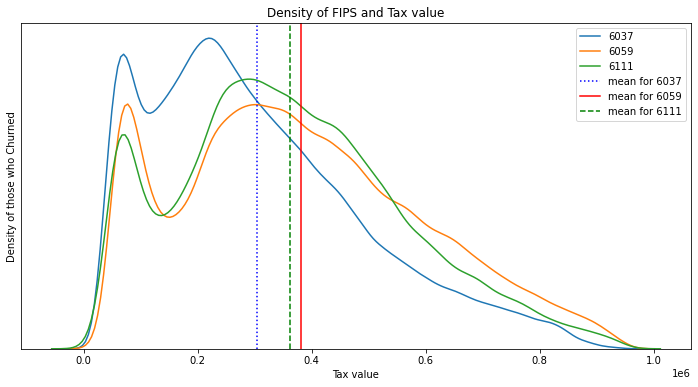

In [65]:
## does a levene test for comparing variance, creates a boolean flag that is passed into the ttest for
## comparing the churned monthly charge and the unchurned monthly charge
## then plots the graphs for a visual


alpha = .05

for fips1 in train.fips.unique():
    for fips2 in train.fips.unique():
        if not train.fips.unique().tolist().index(fips2) >= train.fips.unique().tolist().index(fips1):
            H0 = f"Tax value of FIPS{fips1} has identical average values to Tax value of other FIPS{fips2}"
            Ha = "Tax value of FIPS is not equal to Tax value of other FIPS"
            print("-----------------------------")
            #compare variances to know how to run the test
            stat,pval = stats.levene(train[train.fips == fips1]["tax value"],train[train.fips == fips2]["tax value"])
            stat,pval
            if pval > 0.05:
                equal_var_flag = True
                print(f"we can accept that there are equal variance in these two groups with {round(pval,2)} certainty Flag=T",'stat=%.5f, p=%.5f' % (stat,pval))
            else:
                equal_var_flag = False
                print(f"we can reject that there are equal variance in these two groups with {round((1-pval),2)} certainty Flag=F",'stat=%.5f, p=%.5f' % (stat,pval))


            t, p = stats.ttest_ind( train[train.fips == fips1]["tax value"], train[train.fips == fips2]["tax value"], equal_var = equal_var_flag )

            if p > alpha:
                print("\n We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
            else:
                print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))

plt.figure(figsize=(12,6))
plt.title(f"Density of FIPS and Tax value")


plt.ylabel("Density of those who Churned")
plt.yticks([],[])


sns.kdeplot(train[train.fips == train.fips.unique()[0]]["tax value"],label=f"{train.fips.unique()[0].astype(int)}")
sns.kdeplot(train[train.fips == train.fips.unique()[1]]["tax value"],label=f"{train.fips.unique()[1].astype(int)}")
sns.kdeplot(train[train.fips == train.fips.unique()[2]]["tax value"],label=f"{train.fips.unique()[2].astype(int)}")

plt.axvline(train[train.fips == train.fips.unique()[0]]["tax value"].mean(),
            color="blue",
            ls=":",
            label=f"mean for {train.fips.unique()[0].astype(int)}")
plt.axvline(train[train.fips == train.fips.unique()[1]]["tax value"].mean(),
            color="red",
            ls="-",
            label=f"mean for {train.fips.unique()[1].astype(int)}")
plt.axvline(train[train.fips == train.fips.unique()[2]]["tax value"].mean(),
            color="green",
            ls="--",
            label=f"mean for {train.fips.unique()[2].astype(int)}")

plt.xlabel("Tax value")
plt.legend()
plt.show()

## Takeaway on TTest for FIPS and Tax Value
- the 2 sided TTest yielded interesting results in that the the samples of FIPS did varied enough to pass our statistical significance (alpha = .05). This would indicate that seperating the data by FIPS will result in a significant difference. This will be important for our modeling

-
-
-
-
-

In [66]:
train["bed/bath"] = train["bedrooms"]/train["bathrooms"]
train["yearly taxes per sqft"] = train["taxes yearly"] / train["area"]
train["tax value per taxes yearly per sqft"] = train["tax value"] / train["yearly taxes per sqft"] 
train["tax value binned"] = (((train["tax value"]//50_000)+0) *50_000).astype(int).astype(str) + "-" + (((train["tax value"]//50_000)+1) *50_000).astype(int).astype(str)
train["area binned"] = (((train["area"]//500)+0) *500).astype(int).astype(str) + "-" + (((train["area"]//500)+1) *500).astype(int).astype(str)

import plotly.express as px
import plotly

df = px.data.tips()
fig = px.scatter_3d( data_frame = train.sample(n=10000, random_state=123).sort_values(by=["decade built"]), 
                    #histfunc="avg",
                    z="tax value per taxes yearly per sqft", 
                    x="year built", 
                    y= "yearly taxes per sqft", 
                    #color="fips",
                    size= "taxes yearly",
                    size_max= 10,
                    symbol="fips",
                    #violinmode='overlay',
                    #marginal="box", # or violin, rug,
                    #points="all",
                    #nbins=10,
                   

                    hover_data=train.columns)

fig.update_xaxes(categoryorder='category ascending')
#fig.update_xaxes(categoryorder='total ascending')

fig.update_traces(marker_colorscale="blackbody",selector=dict(type='scatter'))

fig.update_layout(
    scene = dict(xaxis = dict(nticks=10, range=[1920,2010],),
                     yaxis = dict(nticks=6, range=[0,12],),
                     zaxis = dict(nticks=10, range=[0,500_000],),),
    autosize=False,
    width=1500,
    height=800,
    margin=dict(
        l=25,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)

plotly.offline.iplot(fig, validate=False)

In [67]:
train["bed/bath"] = train["bedrooms"]/train["bathrooms"]
train["area by taxes yearly"] = train["area"]/train["taxes yearly"]
train["tax value per taxes yearly per sqft"] = train["tax value"] / train["yearly taxes per sqft"] 
train["tax value binned"] = (((train["tax value"]//50_000)+0) *50_000).astype(int).astype(str) + "-" + (((train["tax value"]//50_000)+1) *50_000).astype(int).astype(str)
train["area binned"] = (((train["area"]//500)+0) *500).astype(int).astype(str) + "-" + (((train["area"]//500)+1) *500).astype(int).astype(str)

train["area by bedrooms"] = train["area"] / train["bedrooms"]
train["tax value by taxes yearly"] = train["tax value"] / train["taxes yearly"]
train["taxes yearly by bed/bath"] = train["taxes yearly"] / train["bed/bath"]

import plotly.express as px
import plotly

df = px.data.tips()
fig = px.scatter_3d( data_frame = train.sample(n=10000, random_state=123).sort_values(by=["decade built"]), 
                    #histfunc="avg",
                    x="area by taxes yearly", 
                    z="tax value by taxes yearly", 
                    y= "taxes yearly by bed/bath", 
                    #color="fips",
                    size= "taxes yearly",
                    size_max= 10,
                    symbol="fips",
                   

                    hover_data=train.columns)

fig.update_xaxes(categoryorder='category ascending')
#fig.update_xaxes(categoryorder='total ascending')

fig.update_traces(marker_colorscale="blackbody",selector=dict(type='scatter'))

fig.update_layout(
    scene = dict(xaxis = dict(nticks=10, range=[0,3],),
                     yaxis = dict(nticks=6, range=[0,15000],),
                     zaxis = dict(nticks=10, range=[0,150],),),
    autosize=False,
    width=1500,
    height=800,
    margin=dict(
        l=25,
        r=50,
        b=25,
        t=25,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)

plotly.offline.iplot(fig, validate=False)

Feature engineering was a hit, we can now see a "curve" that could be modeled
however since 3d models are not allowed in a presentation, we will 2d model it's aspects

<AxesSubplot:xlabel='taxes yearly by bed/bath', ylabel='area by taxes yearly'>

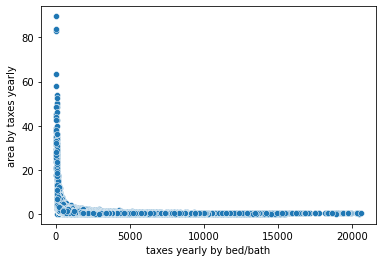

In [68]:
sns.scatterplot(data=train,x="taxes yearly by bed/bath",y="area by taxes yearly")


In [69]:
train

bedrooms  bathrooms    area  tax value  year built  taxes yearly  \
1222525       2.0        1.0  1012.0   294422.0      1949.0       4149.40   
1382660       3.0        2.0  1961.0   627384.0      1953.0       7124.10   
2094882       3.0        2.0  1271.0   328921.0      1956.0       4027.52   
1791732       3.0        2.0  1474.0   542190.0      1927.0       6437.48   
933597        4.0        3.0  2268.0   540066.0      1973.0       6823.28   
...           ...        ...     ...        ...         ...           ...   
1491561       3.0        2.0  1975.0   193653.0      1942.0       2509.65   
1068135       4.0        2.0  2019.0   227067.0      1976.0       3457.68   
1451731       3.0        2.0  1502.0   324583.0      1976.0       3786.58   
1684469       3.0        2.0  1231.0   208556.0      1950.0       2741.15   
1907432       3.0        2.0  2449.0   129932.0      1978.0       1788.21   

           fips decade built  bed/bath  yearly taxes per sqft  \
1222525  6037.0        1940s  2.000000               4.100198   
1382660  6037.0        1950s  1.500000               3.632891   
2094882  6037.0        1950s  1.500000               3.168780   
1791732  6037.0        1920s  1.500000               4.367354   
933597   6037.0        1970s  1.333333               3.008501   
...         ...          ...       ...                    ...   
1491561  6037.0        1940s  1.500000               1.270709   
1068135  6037.0        1970s  2.000000               1.712571   
1451731  6059.0        1970s  1.500000               2.521025   
1684469  6037.0        1950s  1.500000               2.226767   
1907432  6037.0        1970s  1.500000               0.730180   

         tax value per taxes yearly per sqft tax value binned area binned  \
1222525                         71806.782667    250000-300000   1000-1500   
1382660                        172695.501748    600000-650000   1500-2000   
2094882                        103800.500308    300000-350000   1000-1500   
1791732                        124146.103755    500000-550000   1000-1500   
933597                         179513.326142    500000-550000   2000-2500   
...                                      ...              ...         ...   
1491561                        152397.615205    150000-200000   1500-2000   
1068135                        132588.404074    200000-250000   2000-2500   
1451731                        128750.393759    300000-350000   1500-2000   
1684469                         93658.660051    200000-250000   1000-1500   
1907432                        177945.245804    100000-150000   2000-2500   

         area by taxes yearly  area by bedrooms  tax value by taxes yearly  \
1222525              0.243891        506.000000                  70.955319   
1382660              0.275263        653.666667                  88.065019   
2094882              0.315579        423.666667                  81.668372   
1791732              0.228972        491.333333                  84.223951   
933597               0.332391        567.000000                  79.150497   
...                       ...               ...                        ...   
1491561              0.786962        658.333333                  77.163349   
1068135              0.583918        504.750000                  65.670334   
1451731              0.396664        500.666667                  85.719303   
1684469              0.449082        410.333333                  76.083396   
1907432              1.369526        816.333333                  72.660370   

         taxes yearly by bed/bath  
1222525               2074.700000  
1382660               4749.400000  
2094882               2685.013333  
1791732               4291.653333  
933597                5117.460000  
...                           ...  
1491561               1673.100000  
1068135               1728.840000  
1451731               2524.386667  
1684469               1827.433333  
1907432               1192.140000  

[1079657

<AxesSubplot:xlabel='bed/bath', ylabel='tax value per taxes yearly per sqft'>

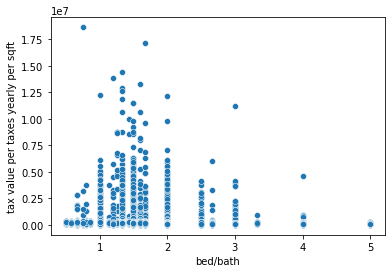

In [70]:
sns.scatterplot(data=train,y="tax value per taxes yearly per sqft",x="bed/bath")


In [71]:
#scale continous data

train_scaled = train.copy()

columns_to_scale = num_vars
scaler = MinMaxScaler()
train_scaled[columns_to_scale] = scaler.fit_transform(train_scaled[columns_to_scale])


In [72]:
X_train,X_validate = train[["taxes yearly"]],validate[["taxes yearly"]]
y_train,y_validate = train["tax value"],validate["tax value"]

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train) ##only use fit_transform for training, after that use transform (equations are created)
X_validate_scaled = scaler.transform(X_validate)

Text(0.5, 1.0, 'Scaled')

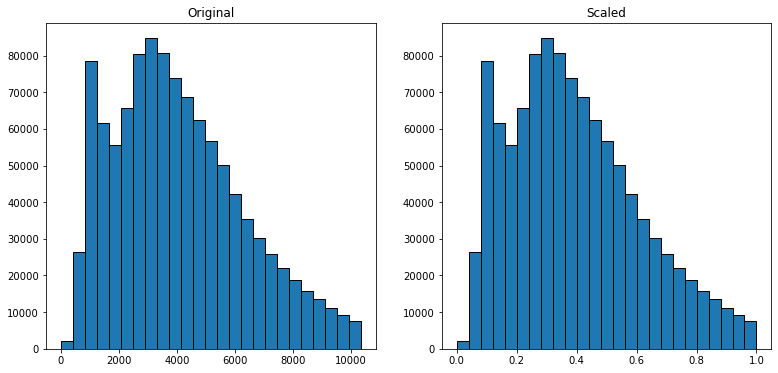

In [73]:
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train_scaled, bins=25, ec='black')
plt.title('Scaled')


-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-

## playing with the data


bin_df = pd.DataFrame()
df = df[df["tax_value"]<500_000]

for col in temp_list:
    bin_df[f"{col} binned"] = pd.cut(df[col],5)
bin_df["fips"] = df.fips
bin_df["dummy"] = 1
bin_df



binned = bin_df.groupby(bin_df.drop(columns=["dummy"]).columns.tolist()).sum().reset_index()
binned = binned[binned.dummy > 0]
binned



import plotly.express as px
import plotly

s_list = [ 'fips','tax_value binned']

all = binned["dummy"].sum()
#binned["percentage"] = (round(((binned["dummy"]/all)*100),3).astype(str) + "%")
binned["percentage"] = (binned["dummy"]/all)

fig = px.sunburst(  binned, 
                    path=s_list,
                    labels=s_list,
                    values='dummy',
                    color = "tax_value binned"
                    )
plotly.offline.plot(fig, validate=False)


